In [19]:
# ==============================================================================
# SECTION 1: SETUP AND ENVIRONMENT CONFIGURATION
# ==============================================================================
print("--- Section 1: Setup and Environment Configuration ---")

# 1.1 Install necessary libraries
# Use the -q flag for a quiet installation
!pip install kaggle tensorflow scikit-learn pandas numpy matplotlib seaborn pyngrok streamlit -q
print("Libraries installed.")

# 1.2 Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense


--- Section 1: Setup and Environment Configuration ---
Libraries installed.


In [20]:
# 1. Install necessary libraries
!pip install -q kaggle kagglehub

# 2. Upload your Kaggle API key (kaggle.json) 🔑
from google.colab import files
import os

print("Please upload your kaggle.json file")
uploaded = files.upload()

# Check if the file was uploaded
if 'kaggle.json' in uploaded:
    # 3. Configure the key
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json # Set permissions to avoid a warning

    # 4. Download and get the path to the dataset using the Python function 📥
    import kagglehub

    print("\nDownloading dataset with kagglehub...")
    path = kagglehub.dataset_download("abdelazizsami/predictive-maintenance-dataset")

    print("\n✅ Setup complete! Your files are ready.")
    print(f"Dataset path: {path}")
    print(f"Files in the directory: {os.listdir(path)}")
else:
    print("\nSkipping setup because kaggle.json was not uploaded.")


import pandas as pd

# Use the full path provided by the output to access your file
file_path = '/kaggle/input/predictive-maintenance-dataset/ai 2020.csv'

# Load the dataset into a DataFrame
df = pd.read_csv(file_path)

# Now you can work with your data
df.head()



Please upload your kaggle.json file


Saving kaggle.json to kaggle.json


✅ Setup complete! Your files are ready.
Dataset path: /kaggle/input/predictive-maintenance-dataset
Files in the directory: ['ai 2020.csv']


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [21]:
# ==============================================================================
# SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)
# ==============================================================================
print("\n--- Section 3: Exploratory Data Analysis (EDA) ---")

# 3.1 Initial Data Inspection
print("Dataset Info:")
df.info()
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nDescriptive Statistics:")
print(df.describe())


--- Section 3: Exploratory Data Analysis (EDA) ---
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF        

In [22]:
# 3.2 Data Cleaning and Initial Transformation
# Drop unique identifier columns that have no predictive value
df_processed = df.drop(['UDI', 'Product ID'], axis=1)
print("\nDropped 'UDI' and 'Product ID' columns.")


Dropped 'UDI' and 'Product ID' columns.


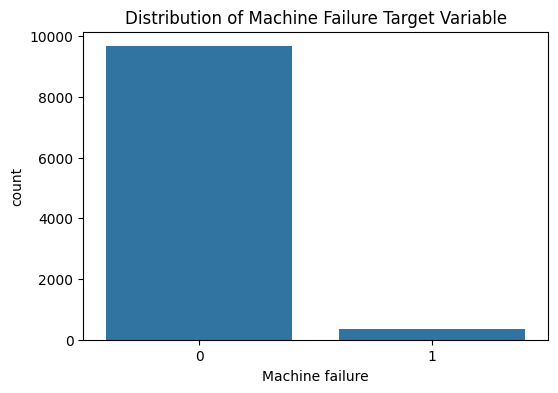

Failure Rate:
Machine failure
0    96.61
1     3.39
Name: proportion, dtype: float64
EDA reveals a significant class imbalance.


In [23]:
# 3.3 Target Variable Analysis
plt.figure(figsize=(6, 4))
sns.countplot(x='Machine failure', data=df_processed)
plt.title('Distribution of Machine Failure Target Variable')
plt.show()
failure_rate = df_processed['Machine failure'].value_counts(normalize=True) * 100
print(f"Failure Rate:\n{failure_rate}")
print("EDA reveals a significant class imbalance.")

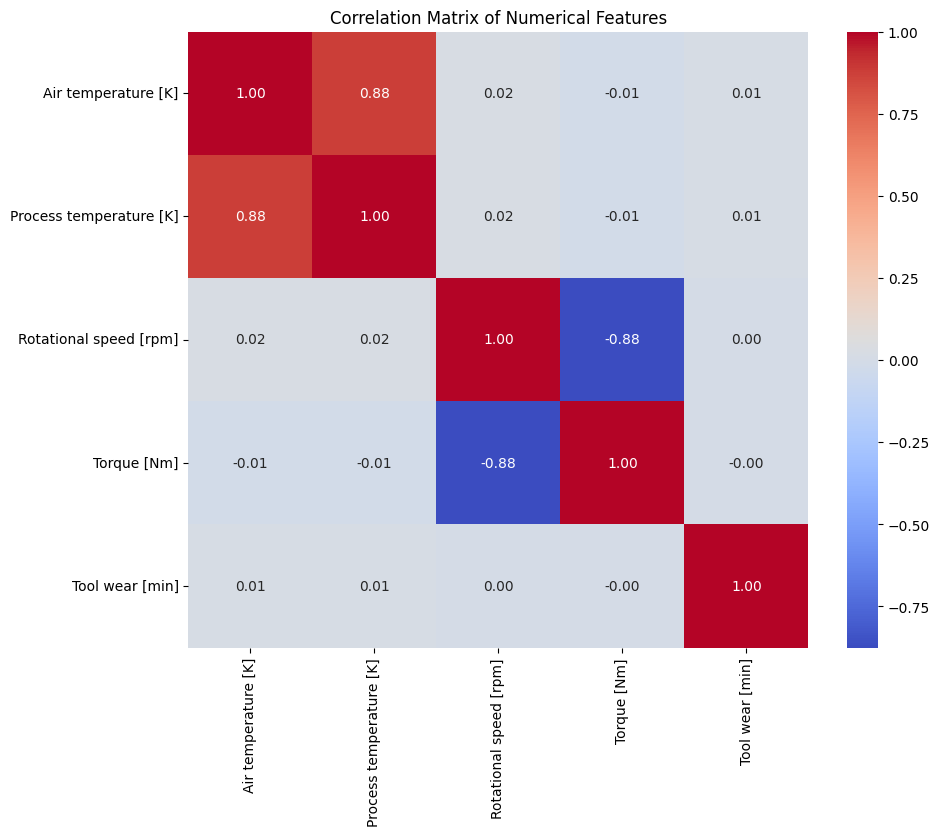

In [24]:
# 3.4 Correlation Analysis
numerical_features = df_processed.select_dtypes(include=np.number).columns.tolist()
# Remove the target variable and specific failure flags for the correlation matrix
features_for_corr = [col for col in numerical_features if col not in ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

plt.figure(figsize=(10, 8))
correlation_matrix = df_processed[features_for_corr].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [25]:
print("\n--- Section 4: Feature Engineering & Preprocessing ---")

# 4.1 Feature Engineering
df_processed['Temp_Diff'] = df_processed['Process temperature [K]'] - df_processed['Air temperature [K]']
df_processed['Power'] = df_processed['Rotational speed [rpm]'] * df_processed['Torque [Nm]'] * (2 * np.pi / 60)
df_processed['Strain_Index'] = df_processed['Tool wear [min]'] * df_processed['Torque [Nm]']
print("Engineered features 'Temp_Diff', 'Power', and 'Strain_Index' created.")

# Drop the specific failure type columns as we are predicting the general 'Machine failure'
df_processed = df_processed.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
print("Dropped specific failure type columns.")



--- Section 4: Feature Engineering & Preprocessing ---
Engineered features 'Temp_Diff', 'Power', and 'Strain_Index' created.
Dropped specific failure type columns.


In [26]:
# 4.2 Define Features (X) and Target (y)
X = df_processed.drop('Machine failure', axis=1)
y = df_processed['Machine failure']


In [27]:
# 4.3 Split Data into Training and Testing Sets
# Using stratify=y to maintain the same proportion of target classes in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split into training and testing sets. Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

Data split into training and testing sets. Training set shape: (8000, 9), Testing set shape: (2000, 9)


In [28]:
# 4.4 Preprocessing Pipeline for Column Transformations
# Identify categorical and numerical columns
categorical_features = ['Type']
# Get all columns from X_train that are not categorical
numerical_features = X_train.drop(columns=categorical_features).columns.tolist()

In [29]:
# Create preprocessing pipelines for numerical and categorical features
# Numerical features will be scaled.
# Categorical features will be one-hot encoded.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transform the test data using the fitted preprocessor
X_test_processed = preprocessor.transform(X_test)

print("Data preprocessing (scaling and encoding) complete.")

Data preprocessing (scaling and encoding) complete.


In [30]:
print("\n--- Section 5: ANN Model Development ---")

# 5.1 Define the ANN Architecture
model = Sequential([
    Dense(32, activation='relu', input_shape=[X_train_processed.shape[1]]),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])



--- Section 5: ANN Model Development ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# 5.2 Compile the Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Model Architecture:")
model.summary()

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# 5.3 Train the Model
print("\nTraining the ANN model...")
history = model.fit(X_train_processed, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2, # Use part of training data for validation
                    verbose=1)


Training the ANN model...
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8198 - loss: 0.4643 - val_accuracy: 0.9656 - val_loss: 0.1672
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9669 - loss: 0.1515 - val_accuracy: 0.9656 - val_loss: 0.1287
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9625 - loss: 0.1273 - val_accuracy: 0.9688 - val_loss: 0.1057
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9738 - loss: 0.0899 - val_accuracy: 0.9700 - val_loss: 0.0986
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9701 - loss: 0.0988 - val_accuracy: 0.9712 - val_loss: 0.0939
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9704 - loss: 0.1000 - val_accuracy: 0.9719 - val_loss: 0.0899
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9746 - loss: 0.0819 - val_accuracy: 0.9688 - val_loss: 0.0914
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9706 - lo


--- Section 6: Model Evaluation ---


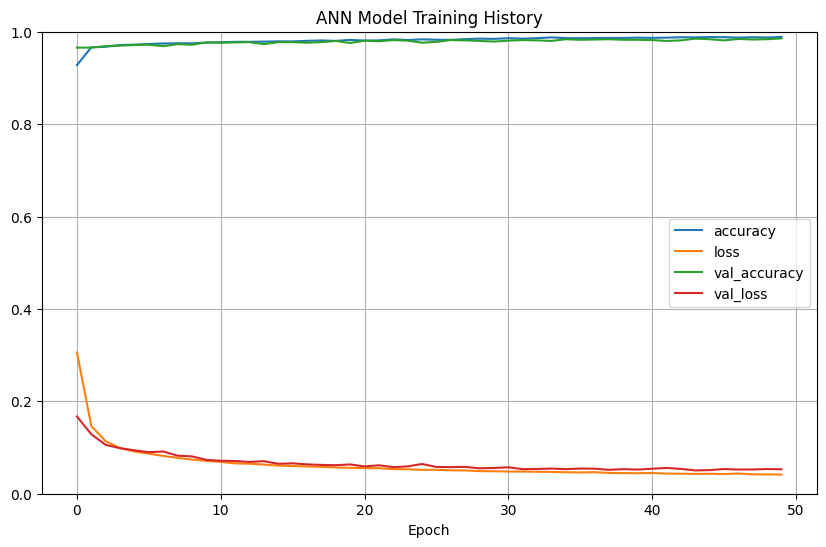

In [33]:
print("\n--- Section 6: Model Evaluation ---")

# 6.1 Plot Training History
pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title('ANN Model Training History')
plt.xlabel('Epoch')
plt.show()


Evaluating ANN on the test set...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

ANN Classification Report:
              precision    recall  f1-score   support

  No Failure       0.98      1.00      0.99      1932
     Failure       0.83      0.44      0.58        68

    accuracy                           0.98      2000
   macro avg       0.91      0.72      0.78      2000
weighted avg       0.98      0.98      0.97      2000

ANN Confusion Matrix:


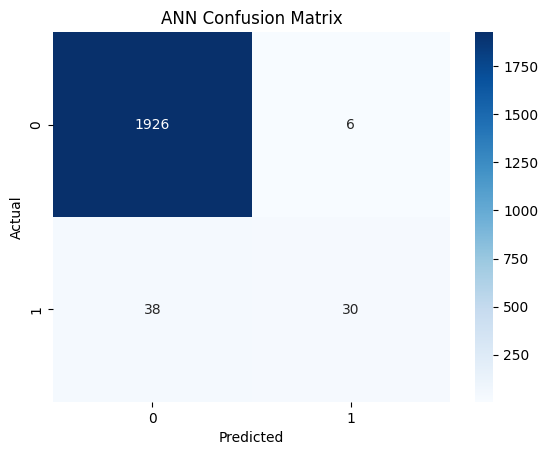

In [34]:
# 6.2 Evaluate on Test Data
print("Evaluating ANN on the test set...")
y_pred_proba = model.predict(X_test_processed)
y_pred_ann = (y_pred_proba > 0.5).astype(int)

print("\nANN Classification Report:")
print(classification_report(y_test, y_pred_ann, target_names=['No Failure', 'Failure']))

print("ANN Confusion Matrix:")
cm_ann = confusion_matrix(y_test, y_pred_ann)
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ANN Confusion Matrix')
plt.show()


In [35]:
print("\n--- Section 7: Benchmarking with Other ML Models ---")

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


--- Section 7: Benchmarking with Other ML Models ---


In [36]:
# Define models to benchmark
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}


--- Evaluating Logistic Regression ---

Logistic Regression Classification Report:
              precision    recall  f1-score   support

  No Failure       0.97      1.00      0.98      1932
     Failure       0.57      0.18      0.27        68

    accuracy                           0.97      2000
   macro avg       0.77      0.59      0.63      2000
weighted avg       0.96      0.97      0.96      2000



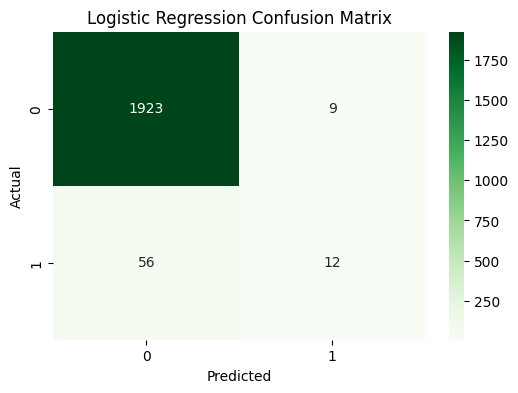


--- Evaluating Random Forest ---

Random Forest Classification Report:
              precision    recall  f1-score   support

  No Failure       0.99      1.00      1.00      1932
     Failure       0.96      0.78      0.86        68

    accuracy                           0.99      2000
   macro avg       0.98      0.89      0.93      2000
weighted avg       0.99      0.99      0.99      2000



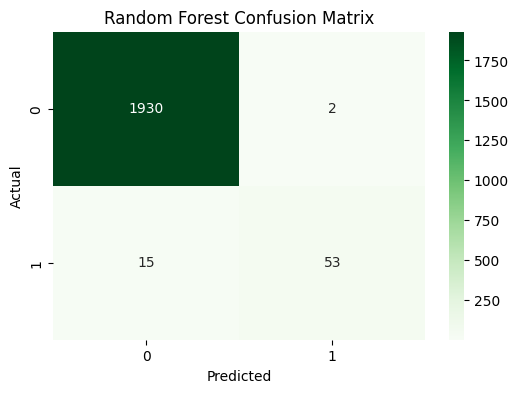


--- Evaluating XGBoost ---

XGBoost Classification Report:
              precision    recall  f1-score   support

  No Failure       0.99      1.00      0.99      1932
     Failure       0.90      0.79      0.84        68

    accuracy                           0.99      2000
   macro avg       0.95      0.90      0.92      2000
weighted avg       0.99      0.99      0.99      2000



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:30:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


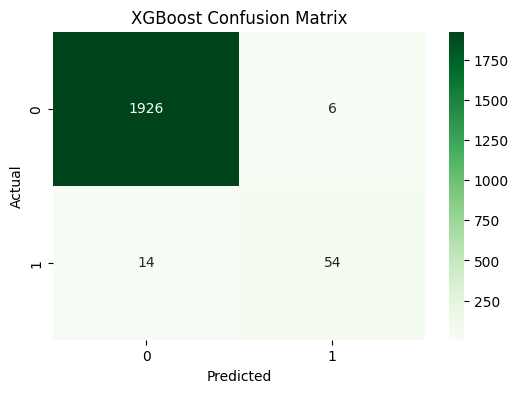

In [37]:
# Train and evaluate each model
for name, benchmark_model in models.items():
    print(f"\n--- Evaluating {name} ---")
    benchmark_model.fit(X_train_processed, y_train)
    y_pred_benchmark = benchmark_model.predict(X_test_processed)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred_benchmark, target_names=['No Failure', 'Failure']))

    cm_benchmark = confusion_matrix(y_test, y_pred_benchmark)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_benchmark, annot=True, fmt='d', cmap='Greens')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [38]:
print("\n--- Section 8: Model Persistence & Deployment Preparation ---")

# 8.1 Save the trained ANN model and the preprocessor
# Using the .h5 format is the standard and more robust way to save Keras models
model.save('ann_model.h5')
print("ANN model saved to ann_model.h5")

with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print("Preprocessor saved to preprocessor.pkl")


--- Section 8: Model Persistence & Deployment Preparation ---
ANN model saved to ann_model.h5
Preprocessor saved to preprocessor.pkl
